<a href="https://colab.research.google.com/github/nishuchy/AI-works/blob/main/Supervised_ML_%E2%80%93_Classification_3_heart_Disease_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup and Import Libraries**

In [3]:
# --- Step 0: Setup and Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer # For handling '?' if present

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report

# For downloading dataset from Kaggle
import opendatasets as od

# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set a random state for reproducibility
RANDOM_STATE = 42

print("Libraries loaded successfully!")





Libraries loaded successfully!


 Step 1: Data Acquisition

In [4]:
# --- Step 1: Data Acquisition ---
print("\n--- Step 1: Data Acquisition ---")
# Download the dataset from Kaggle
# You might need to provide your Kaggle username and API key.
# If you don't have them, you can download the CSV manually and upload it to Colab.
# od.download("https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data")

# Path to the dataset after downloading (adjust if you uploaded manually)
# Assuming it downloads to a folder named 'heart-disease-data'
try:
    df = pd.read_csv("/content/heart_disease_uci.csv")
    print("Dataset loaded using opendatasets.")
except FileNotFoundError:
    print("Dataset not found at 'heart-disease-data/heart_disease_uci.csv'.")
    print("Please ensure you've run `od.download` or uploaded the file manually.")
    # Fallback to direct URL if possible, or instruct user to upload
    # For simplicity, if not using opendatasets, upload 'heart_disease_uci.csv' directly to Colab
    print("Trying to load directly from current directory if uploaded manually...")
    try:
        df = pd.read_csv("heart_disease_uci.csv")
        print("Dataset loaded from current directory.")
    except FileNotFoundError:
        print("Please upload 'heart_disease_uci.csv' to your Google Colab environment.")
        # Exit or raise an error if data cannot be loaded
        exit()

print("Original Data Head:")
print(df.head())
print("\nOriginal Data Info:")
df.info()
print("\nOriginal Data Description:")
print(df.describe())


--- Step 1: Data Acquisition ---
Dataset loaded using opendatasets.
Original Data Head:
   id  age     sex    dataset               cp  trestbps   chol    fbs         restecg  thalch  exang  oldpeak        slope   ca               thal  num
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True  lv hypertrophy   150.0  False      2.3  downsloping  0.0       fixed defect    0
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False  lv hypertrophy   108.0   True      1.5         flat  3.0             normal    2
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False  lv hypertrophy   129.0   True      2.6         flat  2.0  reversable defect    1
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False          normal   187.0  False      3.5  downsloping  0.0             normal    0
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False  lv hypertrophy   172.0  False      1.4    upsloping  0.0             norma

**Step 2: Data Cleaning, Preprocessing, and Wrangling**

In [9]:
# --- Step 2: Data Cleaning, Preprocessing, and Wrangling ---
print("\n--- Step 2: Data Cleaning, Preprocessing, and Wrangling ---")

# Drop 'id' column as it's not useful for prediction
if 'id' in df.columns:
    df = df.drop('id', axis=1)
    print("Dropped 'id' column.")

# Handle missing values: The 'ca' and 'thal' columns in the UCI version often have '?'
# We'll convert '?' to NaN and then impute
df.replace('?', np.nan, inplace=True)
print("\nReplaced '?' with NaN.")

# Convert 'ca' to numeric, as it might have been read as object due to '?'
# 'thal' is a categorical feature and should not be converted to numeric
df['ca'] = pd.to_numeric(df['ca'])
print("Converted 'ca' to numeric.")


# Check for missing values after conversion
print("\nMissing values after '?' conversion and numeric conversion:")
print(df.isnull().sum())

# Define target variable and features
# The target column in this dataset is 'num', not 'target'.
X = df.drop('num', axis=1)
y = df['num']

# Ensure target is binary (some datasets have 0-4 scale, ours is 0/1)
# The 'num' column has values 0, 1, 2, 3, 4. We need to binarize it to 0 (no heart disease) and 1 (heart disease).
y = (y > 0).astype(int)
print(f"\nTarget variable distribution after binarization:\n{y.value_counts()}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Target distribution in training set:\n{y_train.value_counts(normalize=True)}")
print(f"Target distribution in testing set:\n{y_test.value_counts(normalize=True)}")

# Define numerical and categorical features
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print(f"\nNumerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")


# Define preprocessing steps using ColumnTransformer and Pipelines
# Numerical Pipeline: Impute with median (for robustness to outliers), then scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical Pipeline: Impute with most frequent, then One-Hot Encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # handle_unknown='ignore' for new categories in test set
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
          ('cat', categorical_transformer, categorical_features)
    ])

print("\nDefined preprocessing pipelines for numerical and categorical features.")


--- Step 2: Data Cleaning, Preprocessing, and Wrangling ---

Replaced '?' with NaN.
Converted 'ca' to numeric.

Missing values after '?' conversion and numeric conversion:
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

Target variable distribution after binarization:
num
1    509
0    411
Name: count, dtype: int64

Training set shape: (736, 14)
Testing set shape: (184, 14)
Target distribution in training set:
num
1    0.552989
0    0.447011
Name: proportion, dtype: float64
Target distribution in testing set:
num
1    0.554348
0    0.445652
Name: proportion, dtype: float64

Numerical features: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
Categorical features: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

Defined preprocessing pipelines for numerical

Step 3: Exploratory Data Analysis (EDA) ---


--- Step 3: Exploratory Data Analysis (EDA) ---


/tmp/ipython-input-2709689234.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='viridis')


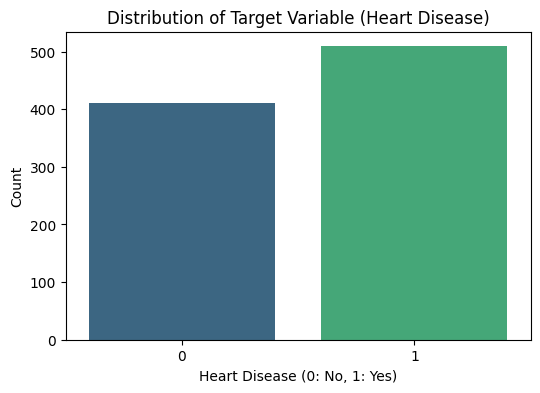

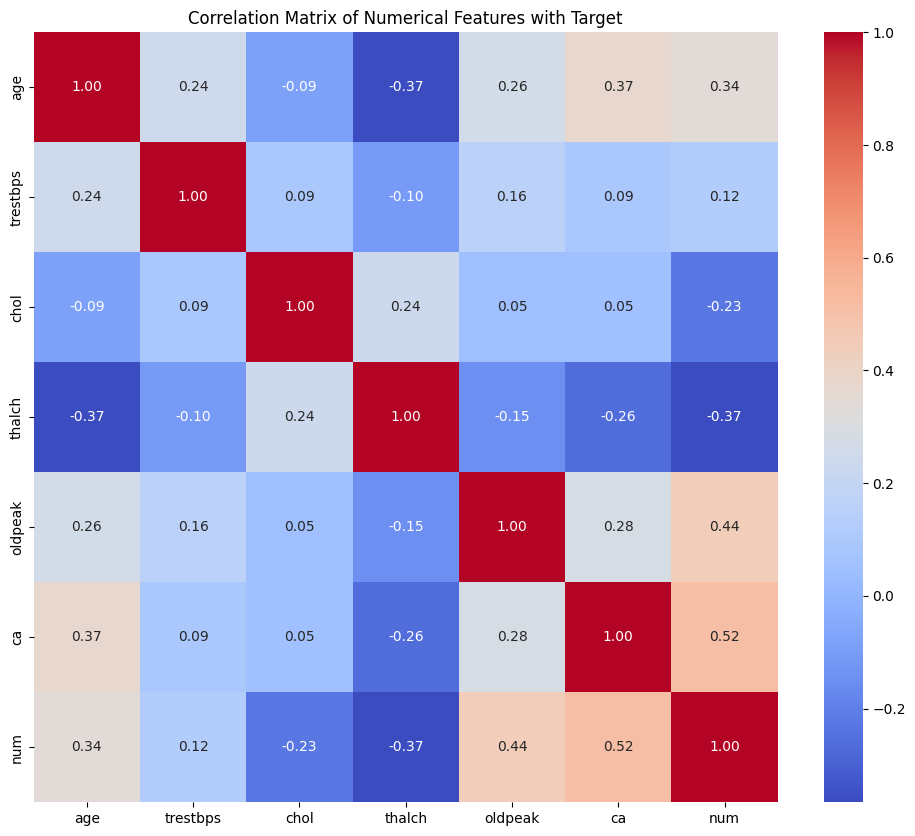

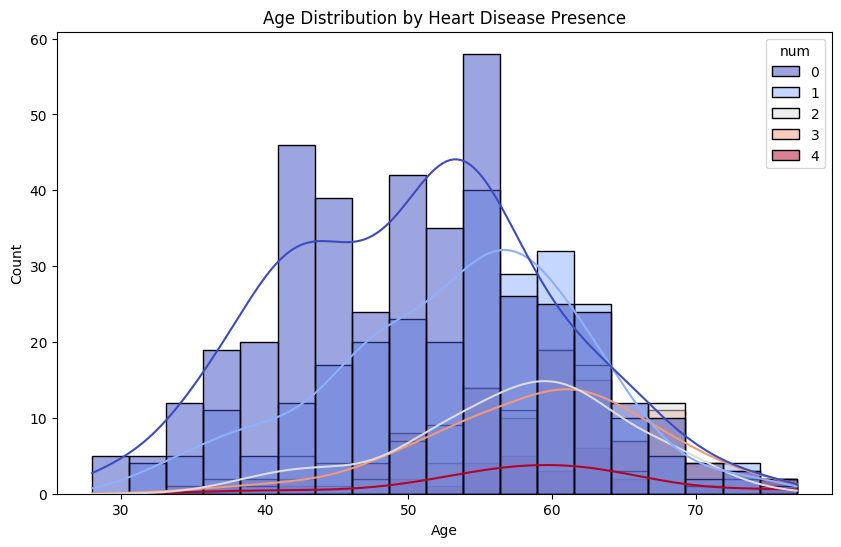

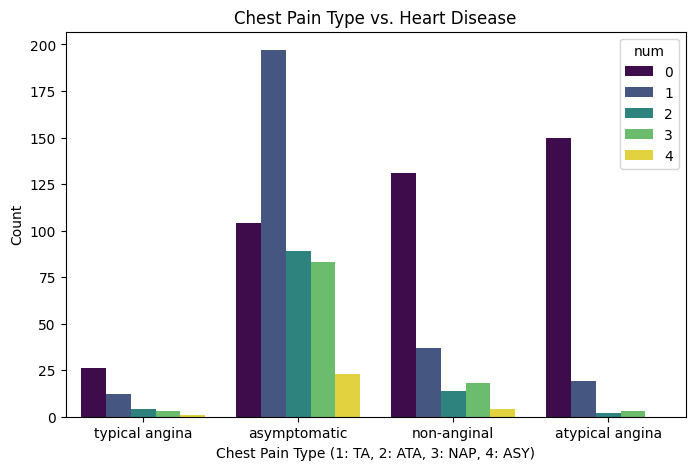

EDA plots generated.


In [13]:
print("\n--- Step 3: Exploratory Data Analysis (EDA) ---")

# Target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette='viridis')
plt.title('Distribution of Target Variable (Heart Disease)')
plt.xlabel('Heart Disease (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

# Correlation Heatmap for numerical features
plt.figure(figsize=(12, 10))
sns.heatmap(df[numerical_features + ['num']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features with Target')
plt.show()

# Example: Distribution of 'age' by 'target'
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='num', kde=True, palette='coolwarm')
plt.title('Age Distribution by Heart Disease Presence')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Example: Chest Pain Type vs. Heart Disease
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='cp', hue='num', palette='viridis')
plt.title('Chest Pain Type vs. Heart Disease')
plt.xlabel('Chest Pain Type (1: TA, 2: ATA, 3: NAP, 4: ASY)')
plt.ylabel('Count')
plt.show()

print("EDA plots generated.")

Step 4 & 5: Model Training, Evaluation, and Performance Metrics


--- Step 4 & 5: Model Training, Evaluation, and Performance Metrics ---

--- Training and Evaluating Logistic Regression ---
Accuracy: 0.8370

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.77      0.81        82
           1       0.83      0.89      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.83      0.83       184
weighted avg       0.84      0.84      0.84       184



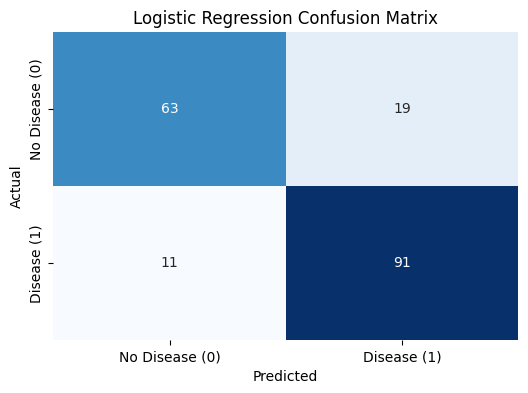

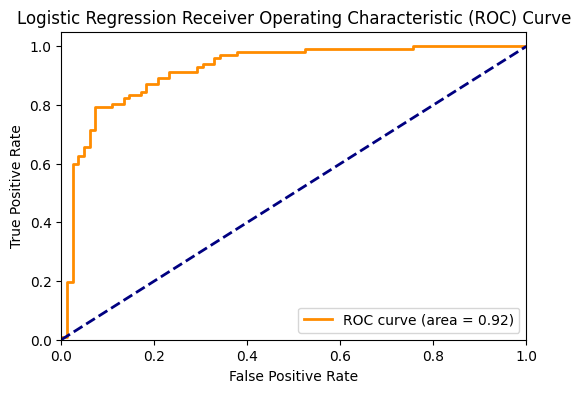


--- Training and Evaluating K-Nearest Neighbors ---
Accuracy: 0.8370

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.77      0.81        82
           1       0.83      0.89      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.83      0.83       184
weighted avg       0.84      0.84      0.84       184



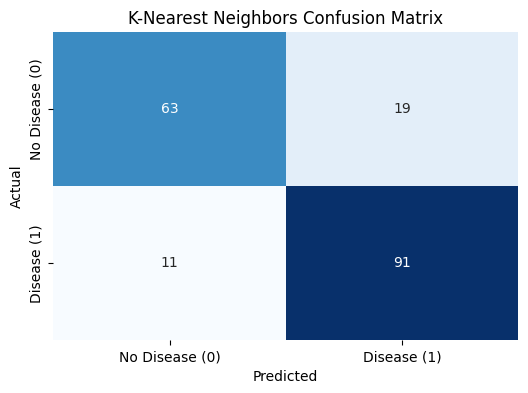

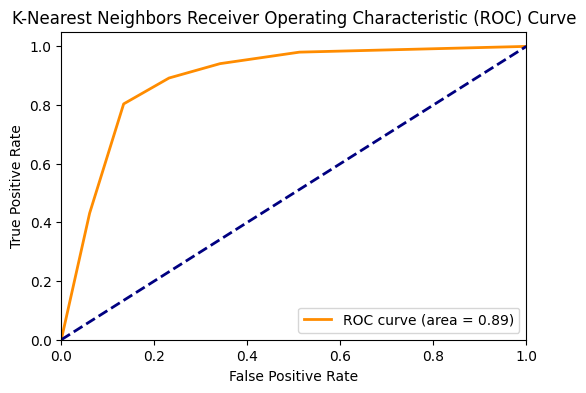


--- Training and Evaluating Support Vector Machine ---
Accuracy: 0.8641

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.77      0.83        82
           1       0.83      0.94      0.88       102

    accuracy                           0.86       184
   macro avg       0.87      0.85      0.86       184
weighted avg       0.87      0.86      0.86       184



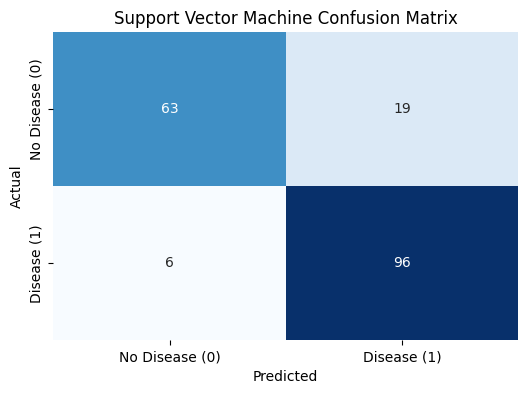

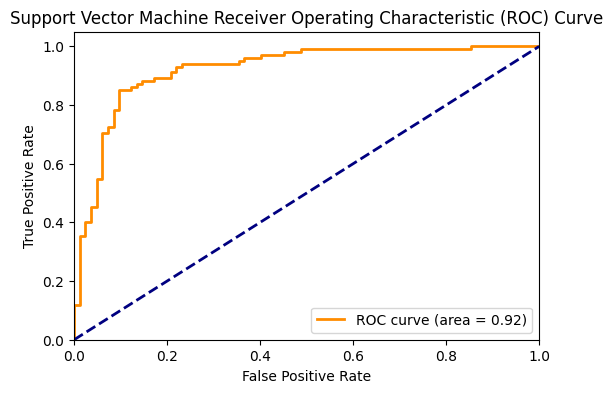


--- Training and Evaluating Decision Tree ---
Accuracy: 0.7663

Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.70      0.73        82
           1       0.77      0.82      0.80       102

    accuracy                           0.77       184
   macro avg       0.77      0.76      0.76       184
weighted avg       0.77      0.77      0.76       184



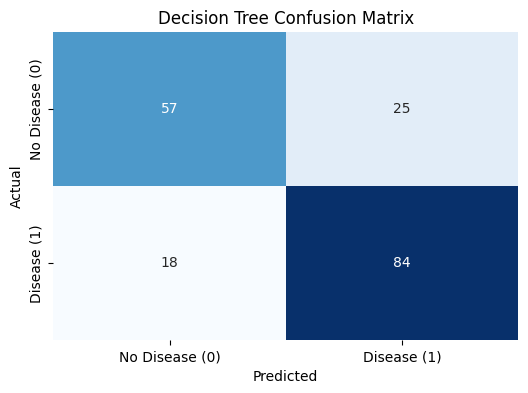

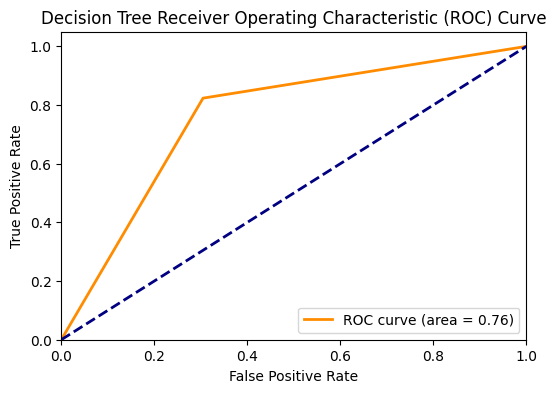


--- Training and Evaluating Random Forest ---
Accuracy: 0.8370

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.80      0.81        82
           1       0.85      0.86      0.85       102

    accuracy                           0.84       184
   macro avg       0.84      0.83      0.83       184
weighted avg       0.84      0.84      0.84       184



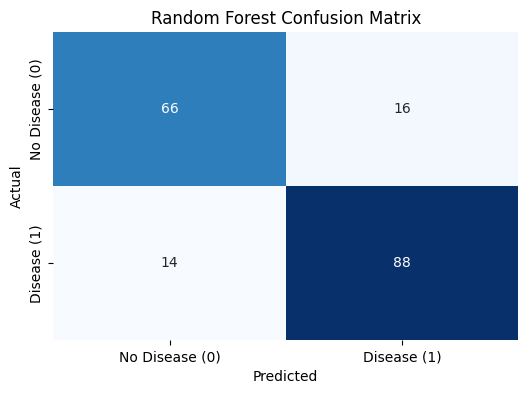

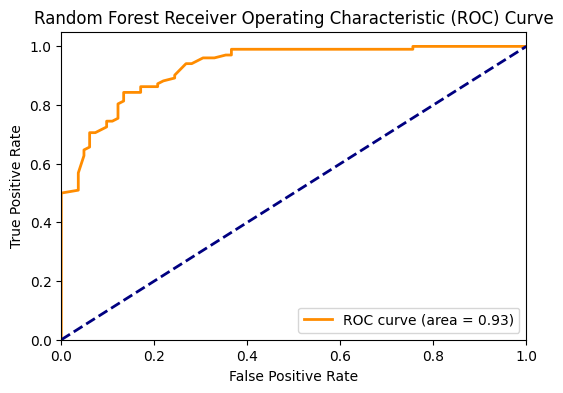


--- Training and Evaluating Gradient Boosting ---
Accuracy: 0.8587

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.79      0.83        82
           1       0.85      0.91      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.85      0.86       184
weighted avg       0.86      0.86      0.86       184



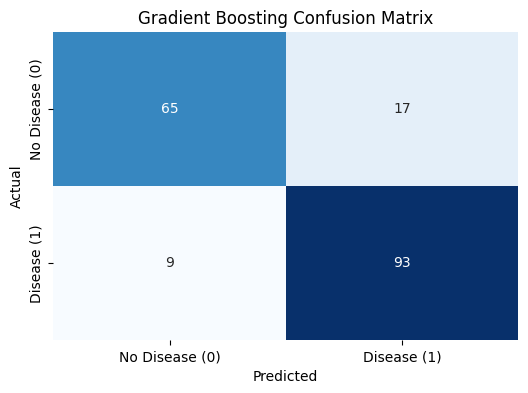

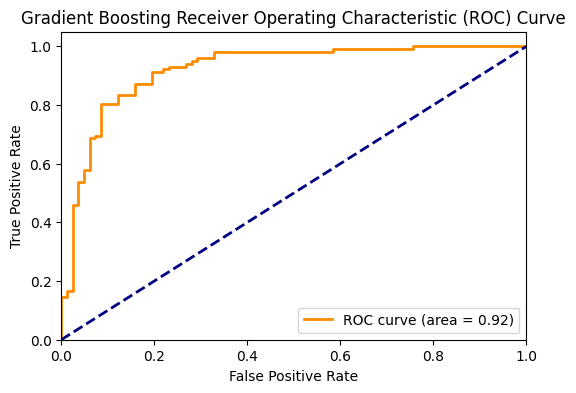

In [14]:

# --- Step 4 & 5: Model Training, Evaluation, and Performance Metrics ---
print("\n--- Step 4 & 5: Model Training, Evaluation, and Performance Metrics ---")

models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=RANDOM_STATE),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(probability=True, random_state=RANDOM_STATE), # probability=True for ROC curve
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE)
}

results = {}

for name, model in models.items():
    print(f"\n--- Training and Evaluating {name} ---")

    # Create a pipeline with preprocessing and the classifier
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    # Train the model
    pipeline.fit(X_train, y_train)
     # Make predictions
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1] # Probability of the positive class for ROC

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, y_proba)

    results[name] = {
        'Accuracy': accuracy,
        'Confusion Matrix': cm,
        'Classification Report': report,
        'ROC AUC': roc_auc,
        'y_pred': y_pred,
        'y_proba': y_proba
    }

    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Disease (0)', 'Disease (1)'],
                yticklabels=['No Disease (0)', 'Disease (1)'])
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

Phase 6: Performance Comparison & Decision Making ---

In [17]:
print("\n--- Phase 6: Performance Comparison & Decision Making ---")

performance_summary = pd.DataFrame()

for name, metrics in results.items():
    acc = metrics['Accuracy']
    precision_1 = metrics['Classification Report']['1']['precision'] # Precision for positive class (1)
    recall_1 = metrics['Classification Report']['1']['recall']     # Recall for positive class (1)
    f1_score_1 = metrics['Classification Report']['1']['f1-score'] # F1-score for positive class (1)
    roc_auc = metrics['ROC AUC']

    performance_summary.loc[name, 'Accuracy'] = f"{acc:.4f}"
    performance_summary.loc[name, 'Precision (Class 1)'] = f"{precision_1:.4f}"
    performance_summary.loc[name, 'Recall (Class 1)'] = f"{recall_1:.4f}"
    performance_summary.loc[name, 'F1-Score (Class 1)'] = f"{f1_score_1:.4f}"
    performance_summary.loc[name, 'ROC AUC'] = f"{roc_auc:.4f}"

print("\n--- Model Performance Summary ---")
print(performance_summary.sort_values(by='ROC AUC', ascending=False))

print("\n--- Decision Making Insights ---")
print("When choosing a model for heart disease prediction, the balance between Precision and Recall is critical.")
print("- **Recall (Sensitivity)**: Minimizing False Negatives (missing actual heart disease cases) is often paramount.")
print("  A higher recall means fewer patients with heart disease are missed, leading to earlier diagnosis and treatment.")
print("- **Precision**: Minimizing False Positives (incorrectly classifying healthy people as having heart disease).")
print("  A higher precision avoids unnecessary anxiety, further tests, and costs for healthy individuals.")
print("- **ROC AUC**: Provides an overall measure of a model's ability to distinguish between classes across all thresholds.")
print("  Higher AUC indicates better discriminative power.")

best_model_name = performance_summary['ROC AUC'].astype(float).idxmax()
print(f"\nBased on ROC AUC, the best performing model is: {best_model_name}")

# Example of making a prediction with the best model
print(f"\n--- Example Prediction with the best model ({best_model_name}) ---")

# Re-train the best model for demonstration purposes (it's already trained in results[best_model_name])
# For a real application, you'd save/load the pipeline.
best_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', models[best_model_name])])
best_pipeline.fit(X_train, y_train) # Fit again if directly taking from `models` dict

# Create a sample new patient data (example values)
# Ensure columns match the original dataframe's columns
sample_patient_data = pd.DataFrame([{
    'age': 55,
    'sex': 'Male',  # Use string values for categorical features
    'dataset': 'Cleveland', # Include dataset column with a representative value
    'cp': 'typical angina',   # Use string values for categorical features
    'trestbps': 130.0, # Resting blood pressure
    'chol': 240.0, # Serum cholestoral in mg/dl
    'fbs': False,  # Fasting blood sugar > 120 mg/dl (True/False)
    'restecg': 'normal', # Resting electrocardiographic results (string values)
    'thalch': 150.0, # Maximum heart rate achieved
    'exang': False,  # Exercise induced angina (True/False)
    'oldpeak': 1.0, # ST depression induced by exercise relative to rest
    'slope': 'downsloping',  # The slope of the peak exercise ST segment (string values)
    'ca': 0.0,   # Number of major vessels (0-3) colored by flourosopy (numeric)
    'thal': 'normal',    # Thalassemia (string values)
    'id': 921, # Include id column with a placeholder value
     'num': 0 # Do NOT include 'num' as it was dropped and replaced by 'target'
}])


print("\nSample Patient Data:")
print(sample_patient_data)

# Make prediction
predicted_class = best_pipeline.predict(sample_patient_data)[0]
predicted_proba = best_pipeline.predict_proba(sample_patient_data)[0]

print(f"\nPredicted Heart Disease (0: No, 1: Yes): {predicted_class}")
print(f"Probability of No Disease: {predicted_proba[0]:.4f}")
print(f"Probability of Disease: {predicted_proba[1]:.4f}")

if predicted_class == 1:
    print(f"\nDecision: Based on the {best_model_name} model, this patient is predicted to have heart disease.")
    print("Recommendation: Further medical examination and consultation are highly recommended.")
else:
    print(f"\nDecision: Based on the {best_model_name} model, this patient is predicted NOT to have heart disease.")
    print("Recommendation: Regular check-ups and monitoring of risk factors are still advisable.")
print("\n--- Tutorial Complete ---")
print("This tutorial demonstrates a full machine learning workflow for supervised classification.")
print("Further steps could involve hyperparameter tuning, cross-validation, and deployment.")


--- Phase 6: Performance Comparison & Decision Making ---

--- Model Performance Summary ---
                       Accuracy Precision (Class 1) Recall (Class 1) F1-Score (Class 1) ROC AUC
Random Forest            0.8370              0.8462           0.8627             0.8544  0.9289
Support Vector Machine   0.8641              0.8348           0.9412             0.8848  0.9218
Gradient Boosting        0.8587              0.8455           0.9118             0.8774  0.9216
Logistic Regression      0.8370              0.8273           0.8922             0.8585  0.9205
K-Nearest Neighbors      0.8370              0.8273           0.8922             0.8585  0.8887
Decision Tree            0.7663              0.7706           0.8235             0.7962  0.7593

--- Decision Making Insights ---
When choosing a model for heart disease prediction, the balance between Precision and Recall is critical.
- **Recall (Sensitivity)**: Minimizing False Negatives (missing actual heart disease cases) is

In [2]:
!pip install opendatasets